In [1]:
#################
####Prepare Data#### cropsize を決める前にちゃんとcnnの中間層のサイズをチェックしなければ
#################

cropsize = 15
import sys,pickle
sys.path.append('/home/koyama-m/Research/source_chaosMaso/')
prefix = '/home/koyama-m/Research/membrane_CNN/data/'
train_path  = prefix + 'training_dataset/256_training_dataset_crop' + str(cropsize) + '/'
test_path = prefix + 'test_dataset/256_test_dataset_crop' + str(cropsize) + '/'
test_path2   = prefix + 'test_dataset/reconstruction_256_test_dataset_crop' + str(cropsize) + '/'

In [5]:
import make_dataset
reload(make_dataset)

make_dataset.make_dataset(train_path, test_path, prefix, cropsize)

189351
44848
now index :0
now index :5000
now index :10000
now index :15000
now index :20000
now index :25000
now index :30000
now index :35000
now index :40000
now index :45000
now index :50000
now index :55000
now index :60000
now index :65000
now index :70000
now index :75000
now index :80000
now index :85000
now index :90000
now index :95000
now index :100000
now index :105000
now index :110000
now index :115000
now index :120000
now index :125000
now index :130000
now index :135000
now index :140000
now index :145000
now index :150000
now index :155000
now index :160000
now index :165000
now index :170000
now index :175000
now index :180000
now index :185000
now index :0
now index :5000
now index :10000
now index :15000
now index :20000
now index :25000
now index :30000
now index :35000
now index :40000


In [2]:
#######################
###### Setup############
#######################
# To do :
#     Monitor validation error.
#     Show Hyperparamters.

import pickle
import numpy as np
from chainer import cuda, Function, FunctionSet, gradient_check, Variable, optimizers
import chainer.functions as F
from matplotlib import pyplot as plt
%matplotlib inline
import logistic_reg, convnet_trial
reload(logistic_reg)
reload(convnet_trial)


###### load dataset ######
data_path ='/home/koyama-m/Research/membrane_CNN/data/'
file_path = data_path+'256_membrane%s.pkl' %str(cropsize)
dataset = pickle.load(open(file_path))
x_train0 = dataset['x_train']/255.
y_train0 = dataset['y_train']
x_test = dataset['x_test']/255.
y_test = dataset['y_test']

In [3]:
neg_index = np.where(y_train0 == 0)[0]
pos_index = np.where(y_train0 == 1)[0]
neg_pos_prop = [neg_index.shape[0], pos_index.shape[0] ]
print neg_pos_prop

validate_index = np.arange(150000, y_train0.shape[0],1)
train_index  = np.arange(0,150000,1)
print validate_index.shape[0]

x_valid = x_train0[validate_index]
y_valid = y_train0[validate_index]
x_train = x_train0[train_index]
y_train = y_train0[train_index]

x_train[1].shape

[94676, 94675]
39351


(15, 15)

In [4]:
##### which do you want to use cnn or logistic regression ?  #####
model_is_cnn = True

##### reshape x for cnn  #####
if(model_is_cnn==True):
    x_train = x_train.reshape((x_train.shape[0],1,x_train.shape[1],x_train.shape[1]))
    x_test = x_test.reshape((x_test.shape[0],1,x_test.shape[1],x_test.shape[1]))
    x_valid = x_valid.reshape((x_valid.shape[0],1,x_valid.shape[1],x_valid.shape[1]))
######### init GPU status #######
cuda.init()

#FXN MUST BE DEFINED BEFORE INITIALIZATION 
######## init models ########
if(model_is_cnn==True):
    model_cpu_ver = convnet_trial.convnet_trial(patchsize=x_train.shape[2])
    model =  convnet_trial.convnet_trial(patchsize=x_train.shape[2]).to_gpu()
else:
    model =  logistic_reg.logistic_r(patchsize=x_train.shape[1]).to_gpu()

######## init optimizer #######
optimizer = optimizers.Adam()
optimizer.setup(model.collect_parameters())
optimizer.zero_grads()

x_train.shape

3.0
3.0


(150000, 1, 15, 15)

Make sure that first row is same as the second row
(100, 1, 15, 15) (25, 1, 15, 15)


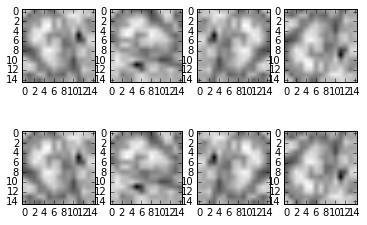

In [5]:
#####################
# Checkin if the data augmentation procedure is correct
#####################

trainsize = x_train.shape[0]
indexes = np.random.permutation(trainsize)

minibatchsize = 25
i = 10
x_traintr = np.transpose(x_train, (0,1,3,2))
x_trainlr  = x_train[:,:,:,::-1]
x_trainud  = x_train[:,:,::-1,:]

x_batch_orig = x_train[indexes[i : i + minibatchsize]]
y_batch_orig = y_train[indexes[i : i + minibatchsize]]

x_batch_tr = x_traintr[indexes[i : i + minibatchsize]]
y_batch_tr = y_train[indexes[i : i + minibatchsize]]        
        
x_batch_lr = x_trainlr[indexes[i : i + minibatchsize]]
y_batch_lr = y_train[indexes[i : i + minibatchsize]]
        
x_batch_ud = x_trainud[indexes[i : i + minibatchsize]]
y_batch_ud = y_train[indexes[i : i + minibatchsize]]
        
pre_x_batch = np.concatenate((x_batch_orig,x_batch_tr, x_batch_lr, x_batch_ud), axis=0)
pre_y_batch = np.concatenate((y_batch_orig,y_batch_tr, y_batch_lr, y_batch_ud), axis=0)

        
cuda.init()        
x_batch = cuda.to_gpu(pre_x_batch)
y_batch = cuda.to_gpu(pre_y_batch)

nn=4

print('Make sure that first row is same as the second row')
patch_index = 4
plt.subplot(2,nn,1)
plt.imshow(x_batch_orig[patch_index][0], cmap = plt.cm.gray)
plt.subplot(2,nn,2)
plt.imshow(x_batch_orig[patch_index][0].transpose(), cmap = plt.cm.gray)
plt.subplot(2,nn,3)
plt.imshow(np.fliplr(x_batch_orig[patch_index][0]), cmap = plt.cm.gray)
plt.subplot(2,nn,4)
plt.imshow(np.flipud(x_batch_orig[patch_index][0]), cmap = plt.cm.gray)


plt.subplot(2,nn,5)
plt.imshow(x_batch_orig[patch_index][0], cmap = plt.cm.gray)
plt.subplot(2,nn,6)
plt.imshow(x_batch_tr[patch_index][0], cmap = plt.cm.gray)
plt.subplot(2,nn,7)
plt.imshow(x_batch_lr[patch_index][0], cmap = plt.cm.gray)
plt.subplot(2,nn,8)
plt.imshow(x_batch_ud[patch_index][0], cmap = plt.cm.gray)


print pre_x_batch.shape,  x_batch_orig.shape

In [6]:
######################
#Model to be used
######################

patchsize = 15


channel1 = 8.
filtsize1 = 3.
padsize1 = 0.
poolsize1 = 2.
stride1 = 2.
        
channel2 = 16.
filtsize2 = 3.
padsize2 = 0.
poolsize2= 2.
stride2 = 2.

num_categ = 2
        

size1 = patchsize - (filtsize1 -1)+ padsize1 *2.
size2 = np.ceil(size1/poolsize1)
size3 = size2 - (filtsize2 -1)+ padsize2 *2.
size4 = np.ceil(size3/poolsize2)

sizef = size4**2*channel2 
print size4

3.0


(100, 1, 15, 15)
(100, 8, 7, 7)  1st Layer
(100, 16, 3, 3)  2nd Layer
(100, 144)  3rd Layer
(100, 2)  4th Layer
(100, 2)


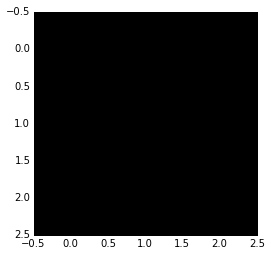

In [7]:
######################
#Verify that the model works
######################

conv1 = F.Convolution2D(1,int(channel1),int(filtsize1))
conv2 = F.Convolution2D(int(channel1),int(channel2),int(filtsize2),pad=0)
fc3 = F.Linear(int(size4)**2*int(channel2),int(size4)**2*int(channel2))
fcf = F.Linear(int(size4)**2*int(channel2), num_categ) 

x_data = pre_x_batch
y_data = pre_y_batch
x = Variable(x_data, volatile=False)
y = Variable(y_data, volatile = False)
print x.data.shape

#1
h = F.max_pooling_2d(F.relu(conv1(x)), (2,2), stride=2)
print h.data.shape, ' 1st Layer'

#2
h = F.max_pooling_2d(F.relu(conv2(h)), (2,2), stride=2)
print h.data.shape, ' 2nd Layer'
plt.imshow(h.data[1][5], cmap = plt.cm.gray)

#3
h = F.relu(fc3(h))
print h.data.shape, ' 3rd Layer'
#4
h = fcf(h)
print h.data.shape, ' 4th Layer'

pred = F.softmax(h)
print h.data.shape

In [8]:
x_train.shape

(150000, 1, 15, 15)

In [9]:
reload(convnet_trial)
model_cpu_ver = convnet_trial.convnet_trial(patchsize=x_train.shape[2])
model_cpu_ver.forward(x_data,y_data)

3.0


(<chainer.variable.Variable at 0x7f69692e4950>,
 <chainer.variable.Variable at 0x7f69692e47d0>)

In [10]:
#######################
######Training###########
#######################

trainsize = x_train.shape[0]
validsize = x_valid.shape[0]

#Data Augmentation
x_traintr = np.transpose(x_train, (0,1,3,2))
x_trainlr  = x_train[:,:,:,::-1]
x_trainud  = x_train[:,:,::-1,:]

minibatchsize = 50
for epoch in xrange(200):
    indexes = np.random.permutation(trainsize)
    n_batch = indexes.shape[0]/minibatchsize
    sum_loss = 0
    sum_accuracy = 0
    for i in xrange(0, trainsize, minibatchsize):
        
        x_batch_orig = x_train[indexes[i : i + minibatchsize]]
        y_batch_orig = y_train[indexes[i : i + minibatchsize]]

        x_batch_tr = x_traintr[indexes[i : i + minibatchsize]]
        y_batch_tr = y_train[indexes[i : i + minibatchsize]]        

        x_batch_lr = x_trainlr[indexes[i : i + minibatchsize]]
        y_batch_lr = y_train[indexes[i : i + minibatchsize]]

        x_batch_ud = x_trainud[indexes[i : i + minibatchsize]]
        y_batch_ud = y_train[indexes[i : i + minibatchsize]]

        pre_x_batch = np.concatenate((x_batch_orig,x_batch_tr, x_batch_lr, x_batch_ud), axis=0)
        pre_y_batch = np.concatenate((y_batch_orig,y_batch_tr, y_batch_lr, y_batch_ud), axis=0)        
        
        x_batch = cuda.to_gpu(pre_x_batch)
        y_batch = cuda.to_gpu(pre_y_batch)
        optimizer.zero_grads()
        
        loss, accuracy,pred = model.forward(x_batch, y_batch)

        sum_loss += loss.data*minibatchsize
        sum_accuracy += accuracy.data*minibatchsize
        loss.backward()
        optimizer.update()
        #print 'train loss:' + str(loss.data)
        #print 'train accuracy(%)' + str(accuracy.data)
    
    sum_val_loss = 0
    sum_val_accuracy = 0
    for i in xrange(0,validsize,minibatchsize):
        x_batch = cuda.to_gpu(x_valid[i : i + minibatchsize])
        y_batch = cuda.to_gpu(y_valid[i : i + minibatchsize])
        loss, accuracy,pred = model.forward(x_batch, y_batch,False)
        sum_val_loss += loss.data*minibatchsize
        sum_val_accuracy += accuracy.data*minibatchsize
    
    print 'epoch ', epoch
    print 'train loss:' + str(sum_loss/trainsize)
    print 'train accuracy(%)' + str(sum_accuracy/trainsize*100)
    print 'validation loss' + str(sum_val_loss/validsize)    
    print 'validation accuracy(%)' + str(sum_val_accuracy/validsize*100)    
    

epoch  0
train loss:0.667982395833
train accuracy(%)58.2841666667
validation loss0.640897035599
validation accuracy(%)63.5714454651
epoch  1
train loss:0.649266614583
train accuracy(%)61.5096666667
validation loss0.63242328167
validation accuracy(%)65.1088943481
epoch  2
train loss:0.64144609375
train accuracy(%)62.3996666667
validation loss0.624333620071
validation accuracy(%)65.0123214722
epoch  3
train loss:0.634130885417
train accuracy(%)63.08
validation loss0.619448900223
validation accuracy(%)65.8814239502
epoch  4
train loss:0.63021796875
train accuracy(%)63.5531666667
validation loss0.611960887909
validation accuracy(%)66.5421447754
epoch  5
train loss:0.626600208333
train accuracy(%)63.9123333333
validation loss0.608135223389
validation accuracy(%)66.872505188
epoch  6
train loss:0.6232778125
train accuracy(%)64.2318333333
validation loss0.610888123512
validation accuracy(%)66.5599365234


KeyboardInterrupt: 

In [ ]:
modelname = 'trained_model%s.pkl' %cropsize
pickle.dump(model, open(modelname,'wb'),-1)

In [ ]:
threshold = 0.5

#######################
###### Testing ###########
#######################
testsize = x_test.shape[0]
minibatchsize = 1000
sum_loss = 0
sum_accuracy = 0
confusion_matrix = np.zeros((2,2))
for i in xrange(0, testsize, minibatchsize):
        x_batch = cuda.to_gpu(x_test[i : i + minibatchsize])
        y_batch = cuda.to_gpu(y_test[i : i + minibatchsize])
        loss, accuracy, prob = model.forward(x_batch, y_batch,train=False)
        sum_loss += loss.data*minibatchsize
        sum_accuracy += accuracy.data*x_batch.shape[0]
        #pred = cuda.to_cpu(prob.data)[:,0]>threshold
        pred = np.argmax(cuda.to_cpu(prob.data),axis=1)
        
        #calc confusion matrix
        for j in xrange(x_batch.shape[0]):
            confusion_matrix[cuda.to_cpu(y_batch)[j],pred[j]] += 1
print 'test loss:' + str(sum_loss/testsize)


print 'chance lebel(accuracy)' + str((np.sum(confusion_matrix[0,:])/np.sum(confusion_matrix)))
print 'test accuracy(%)' + str((confusion_matrix[0,0]+confusion_matrix[1,1])/np.sum(confusion_matrix))

print 'confusion_matrix:'
print confusion_matrix

In [ ]:
y_batch_orig.shape, x_batch_orig.shape

In [ ]:
model_cpu_ver.forward(pre_x_batch, pre_y_batch)